# Imports

In [1]:
import sklearn.svm
import sklearn.neural_network
import sklearn.tree
import sklearn.ensemble
import sklearn.svm
import sklearn.neural_network

import wasmshield.evaluator.malware
import wasmshield.training.trainer
import wasmshield.preprocessing
import warnings
import sklearn.exceptions
import wasmshield.training.trainer
import pandas as pd
import wasmshield.models.resbin

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=sklearn.exceptions.UndefinedMetricWarning)
device = 'mps'


/opt/homebrew/Caskroom/miniforge/base/envs/datascience/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-05-13 09:35:08.039266: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-13 09:35:08.039632: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Loading evaluator

In [2]:
malware_evaluator = wasmshield.evaluator.malware.MalwareEvaluator(
    device
)

# Loading models

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import catboost

In [4]:
size=64
vec_size = 128
reduction = 'max'
temp = 0.15
model_name_getter = lambda size, vec_size, reduction, temp: (
    f'Emprique60_ResBin18_b64_i{size}_pil_v{vec_size}_r{reduction}_t{temp}'.replace('.','')
)
import wasmshield.training.trainer
import wasmshield.models.resbin
from wasmshield.models.resbin import *

model_name_18 = 'Emprique60_2_ResBin18_b64_i64_pil_v128_rmax_t015'
trainable_model_18 = wasmshield.training.trainer.TrainableModel(model=None, name=model_name_18, device=device)
resbin_18_sa = wasmshield.models.resbin.ResBinHandler(
    trainable_model_18.model.backbone
)

model_name_8 = 'Emprique60_2_ResBin8_b64_i64_pil_v128_rmax_t015'
trainable_model_8 = wasmshield.training.trainer.TrainableModel(model=None, name=model_name_8, device=device)
resbin_8_sa = wasmshield.models.resbin.ResBinHandler(
    trainable_model_8.model.backbone
)

model_name_18_woSA= 'Emprique60_2_ResBin18_woSA_b64_i64_pil_v128_rmax_t015'
trainable_model_18_woSA = wasmshield.training.trainer.TrainableModel(model=None, name=model_name_18_woSA, device=device)
resbin_18 = wasmshield.models.resbin.ResBinHandler(
    trainable_model_18_woSA.model.backbone
)

model_name_8_woSA = 'Emprique60_2_ResBin8_woSA_b64_i64_pil_v128_rmax_t015'
trainable_model_8_woSA = wasmshield.training.trainer.TrainableModel(
    model=None, 
    name=model_name_8_woSA, 
    device=device
)
resbin_8 = wasmshield.models.resbin.ResBinHandler(
    trainable_model_8_woSA.model.backbone
)

import wasmshield.approaches.jabberwock
from gensim.models import Doc2Vec

doc2vec = Doc2Vec.load('models/doc2vec_mal.model')

jabberwock_handler = wasmshield.approaches.jabberwock.JabberWockHandler(
    doc2vec, 
    save_vectors_in="/Volumes/Walid-SSD/ESI/PFE/DATASETS/jabberwock_mal_vectors_128/",
)


Attempting to load model_name=Emprique60_2_ResBin18_b64_i64_pil_v128_rmax_t015
Attempting to load model_name=Emprique60_2_ResBin8_b64_i64_pil_v128_rmax_t015
Attempting to load model_name=Emprique60_2_ResBin18_woSA_b64_i64_pil_v128_rmax_t015
Attempting to load model_name=Emprique60_2_ResBin8_woSA_b64_i64_pil_v128_rmax_t015


# Loading classifiers

In [5]:
from wasmshield.models.base_classifier import BaseClassifier, SklearnClassifier
import wasmshield.approaches.minos
import wasmshield.models.resbin
import keras

sklearn_model_loaders = [
    (
        'CatBoost',
        lambda : catboost.CatBoostClassifier(n_estimators=2000,verbose=False),
    ),
]

jb_handler = lambda d : (
    wasmshield.approaches.jabberwock.JabberWockHandler(
        d, 
        save_vectors_in="/Volumes/Walid-SSD/ESI/PFE/DATASETS/jabberwock_mal_vectors_128/",
    )
)

handlers = [
    (
        'JabberWock', 
        jb_handler,
        doc2vec,
    ),
    (
        'ResBin8', 
        wasmshield.models.resbin.ResBinHandler, 
        trainable_model_8_woSA.model.backbone
    ),
    (
        'ResBin18', 
        wasmshield.models.resbin.ResBinHandler, 
        trainable_model_18_woSA.model.backbone
    ),
    (
        'ResBin8-SA', 
        wasmshield.models.resbin.ResBinHandler, 
        trainable_model_8.model.backbone
    ),
    (
        'ResBin18-SA', 
        wasmshield.models.resbin.ResBinHandler, 
        trainable_model_18.model.backbone
    ),
]

model_names:list[str] = []
classifiers:list[BaseClassifier] = []

for cls_name, cls_model_loader in sklearn_model_loaders:
    for handler_name, handler, model in handlers:
        model_names.append(
            f'{handler_name}+{cls_name}'
        )
        classifiers.append(
            SklearnClassifier(
                handler_cls=handler,
                model=model,
                classifier_model=cls_model_loader()
            ),
        )

minos_model = wasmshield.approaches.minos.build_minos_cnn()
minos_classifier = wasmshield.approaches.minos.MinosClassifier(
    minos_model,
)
model_names.append('MINOS(re-trained)')
classifiers.append(minos_classifier)


minos_model = keras.models.load_model('wasmshield/approaches/original23.h5')
minos_classifier = wasmshield.approaches.minos.PreTrainedMinosClassifier(
    minos_model,
)
model_names.append('MINOS(pre-trained)')
classifiers.append(minos_classifier)



# Training models and classifiers

In [7]:
all_dict = {}
all_dict['classifiers'] = classifiers
all_dict['model_names'] = model_names

In [8]:
import wasmshield.approaches.minos

all_dict.update(malware_evaluator.train_many_models(classifier_models=classifiers))


(954, 10000) (954, 2)
Epoch 1/20


2024-05-13 09:36:30.853450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 25ms/step - loss: 6.8265 - accuracy: 0.6153
Epoch 2/20
30/30 [==============================] - 1s 22ms/step - loss: 0.6474 - accuracy: 0.7432
Epoch 3/20
30/30 [==============================] - 1s 22ms/step - loss: 0.2735 - accuracy: 0.8784
Epoch 4/20
30/30 [==============================] - 1s 22ms/step - loss: 0.2937 - accuracy: 0.9046
Epoch 5/20
30/30 [==============================] - 1s 23ms/step - loss: 0.1773 - accuracy: 0.9350
Epoch 6/20
30/30 [==============================] - 1s 24ms/step - loss: 0.1952 - accuracy: 0.9423
Epoch 7/20
30/30 [==============================] - 1s 21ms/step - loss: 0.3104 - accuracy: 0.9591
Epoch 8/20
30/30 [==============================] - 1s 21ms/step - loss: 0.0421 - accuracy: 0.9853
Epoch 9/20
30/30 [==============================] - 1s 21ms/step - loss: 0.2557 - accuracy: 0.9738
Epoch 10/20
30/30 [==============================] - 1s 21ms/step - loss: 0.0116 - accuracy: 0.9969
Epoch 11/20
30/30 [=

# Evaluation

In [9]:
all_dict.update(malware_evaluator.eval_malware_evolution(classifier_models=classifiers))

2024-05-13 09:38:53.942835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-05-13 09:39:12.747203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# Results

## Real Malware detection (wasm-mutate evolution)

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.patheffects as pe
plt.style.use('default')
plt.rcParams["axes.grid"] = True

colors = [
  '#fdcc8a','#fc8d59','#ff6361','#d7301f',
  '#ffa600',
  '#00c6ff',]
palette = sns.color_palette(
  colors
)

def plot_all_time(plot_df:pd.DataFrame, ylabel, xlabel, legend, ax, legend_bbox_to_anchor=(0.5, -0.12), ncol_legend=4,):
    plot_df_cp = plot_df.copy()
    mapper = {
        'ResBin8':0,
        'ResBin8-SA':1,
        'ResBin18':2,
        'ResBin18-SA':3,
        'JabberWock':4,
        'MINOS':5,
    }
    g = sns.barplot(
        plot_df_cp.sort_values('model_name', key=lambda l: [mapper[x] for x in l]), 
        x='Tool', 
        y=ylabel, 
        hue='model_name', 
        palette=palette, 
        width=0.95,
        ax=ax,
        saturation=1,
    )
    plt.ylabel(ylabel, fontsize=16)
    plt.xlabel(xlabel, fontsize=16)
    plt.legend(title=legend, fontsize=16)
    g.tick_params(axis='x', labelsize=16)
    g.tick_params(axis='y', labelsize=16)

    _patterns = [ "|" , "O", "\\" , '*' ,  'x', ".", "-", "/", "+" ,]
    patterns = []
    nb_file_sizes = len(plot_df_cp['Tool'].unique())
    for _pat in _patterns:
        patterns += ([_pat]*nb_file_sizes)
        
    for idx, i in enumerate(g.containers):
        g.bar_label(i, fmt='%.4f', rotation=0, padding=14 if idx%2==1 else -1, path_effects=[pe.withStroke(linewidth=3, foreground="white"), ], weight='bold', fontsize=14)
    for idx, i in enumerate(g.patches):
        i.set_hatch(patterns[idx%len(patterns)])

    ax.legend(loc='upper center', bbox_to_anchor=legend_bbox_to_anchor,
          fancybox=True, shadow=True, ncol=ncol_legend, fontsize=16)
    plt.show()


In [58]:

def plot_evolution(all_dict:dict, plots:list, xlabel:str, renamer={}):
    df_plot = pd.DataFrame.from_dict(all_dict)
    for k,v in renamer.items():
        df_plot['model_names'] = [x.replace(k,v) for x in df_plot['model_names']]

    rounder=50

    def myround(x, base=5):
        return base * round(x/base)

    x = [myround(x,rounder) for x in malware_evaluator.results_malware_val.keys()]

    fig, axes = plt.subplots(1,len(plots), figsize=(11,5), facecolor='white')
    fig.tight_layout(pad=2, w_pad=3)

    for ax, (class_name, y_getter, y_name) in zip(axes, plots):

        records = []
        for _ , row in df_plot.iterrows():
            y = y_getter(row['results_evolution_lists'])
            records.extend(
                [
                    {
                        'depth' : a,
                        y_name : b,
                        'model_name' : row['model_names']
                    }
                    for a,b in zip(x,y)
                ]
            )

        plot_df = pd.DataFrame.from_records(records)
        mapper = {
            'ResBin8':(0,(100,100)),
            'ResBin8-SA':(1,(1,1)),
            'ResBin18':(2,(2,1)),
            'ResBin18-SA':(3,(2,2)),
            'JabberWock':(4,(100,100)),
            'MINOS':(5,(2,2)),
        }
        palette = sns.color_palette("tab10", n_colors=len(df_plot))
        l = plot_df['model_name'].unique()
        names = sorted(l, key=lambda x:mapper[x.split('+')[0].split('(')[0]][0])
        g = sns.lineplot(
            plot_df.sort_values(
                'model_name', key=lambda l: [
                    mapper[x.split('+')[0].split('(')[0]][0] for x in l
                ]
            ),
            x='depth', 
            y=y_name, 
            hue='model_name', 
            markersize=10,
            palette=palette,
            ax=ax,
        )
        g.set_yticks(np.arange(0, 1.05, 0.05))
        g.legend().remove()
        g.set_xlabel(xlabel, fontsize=12)
        g.set_ylabel(y_name, fontsize=12)
        g.tick_params(axis='x', labelsize=12)
        g.tick_params(axis='y', labelsize=12)

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

    unique_labels = names

    legend_dict = dict(zip(labels, lines))

    unique_lines = [legend_dict[x] for x in unique_labels]

    fig.legend(
        unique_lines, 
        unique_labels,
        loc='upper center', 
        bbox_to_anchor=(0.5, 0.0),
        fancybox=True, 
        shadow=True, 
        ncol=4,
        fontsize=12,
    )



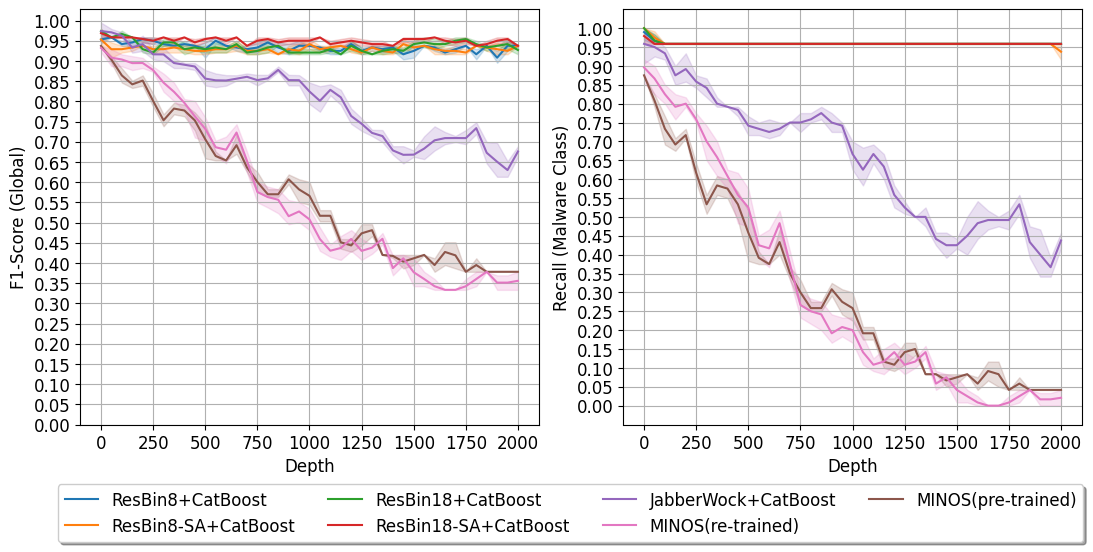

In [60]:
plot_evolution(
    all_dict, 
    plots=[
        ('weighted avg', lambda result_dicts : [x['weighted avg']['f1-score'] for x in result_dicts], 'F1-Score (Global)'),
        ('1', lambda result_dicts : [x['1']['recall'] for x in result_dicts], 'Recall (Malware Class)'),
    ], 
    xlabel='Depth',
)

## Real Malware detection (wasm-mutate overall)

In [45]:
import numpy as np
import pandas as pd
from matplotlib.patches import Patch


mapper = {
      'ResBin8':0,
      'ResBin8-SA':1,
      'ResBin18':2,
      'ResBin18-SA':3,
      'JabberWock':4,
      'MINOS(pre-trained)':6,
      'MINOS(re-trained)':5,
      'MINOS(pré-entraîné)':6,
      'MINOS(ré-entraîné)':5,
}

pos_mapper = {
      'JabberWock':0,
      'ResBin8':0,
      'ResBin8-SA':0,
      'ResBin18':20,
      'ResBin18-SA':20,
      'MINOS(pre-trained)':0,
      'MINOS(re-trained)':20,
      'MINOS(pré-entraîné)':0,
      'MINOS(ré-entraîné)':20,
}

colors = [
      '#fdcc8a',#R8
      '#fc8d59',#R8SA
      '#ff6361',#R18
      '#d7301f',#R18SA
      '#ffa600', #JW
      '#00c6ff',#MINOS
      '#004d63',#MINOS
]

def plot_bar(df:pd.DataFrame, x, y, hue, ax, xlabel):

      group = df[x].tolist()
    
      alg = df[hue].tolist()
      
      alg_colors = [colors[mapper[c]] for c in alg]

      results = df[y].tolist()

      dist_groups = 0.4 
      pos = (np.array([0] + [g1 != g2 for g1, g2 in zip(group[:-1], group[1:])]) * dist_groups + 1).cumsum()
      labels = [g1 for g1, g2 in zip(group[:-1], group[1:]) if g1 != g2] + group[-1:]
      label_pos = [
            sum([p for g, p in zip(group, pos) if g == label]) / len([1 for g in group if g == label])  
            for idx,label in enumerate(labels)
      ]
      
      bars = ax.bar(
            pos, 
            results, 
            color=alg_colors, 
            label=df['model_name'],
            width=1,
            edgecolor = "black",
      )
      ax.set_xticks(label_pos, labels)

      _patterns=["|" , "O", "\\" , '*' ,  'x', ".", "-", "/", "+" ]

      for idx, i in enumerate(bars.patches):
            i.set_hatch(_patterns[mapper[i.get_label()]%len(_patterns)])
     
      ax.legend().remove()

      ax.set_ylabel(y,fontsize=16)
      ax.set_xlabel(xlabel,fontsize=16)
      ax.margins(x=0.04)
      ax.tick_params(axis='x', labelsize=16)
      ax.tick_params(axis='y', labelsize=16)

      fmt='%.4f'
      barlabels = ax.bar_label(
           bars, fmt=fmt, 
           path_effects=[pe.withStroke(linewidth=3, foreground="white"), ], 
           weight='bold', fontsize=14,
      )

      [barlabels[i].set_y(pos_mapper[bars.patches[i].get_label()]) for i in range(len(barlabels))]

def plot_barplot(plot_df, xlabel,renamer):

      for k,v in renamer.items():
            plot_df['model_name'] = [x.replace(k,v) for x in plot_df['model_name']]

      fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), facecolor='white')
      fig.tight_layout(pad=2, w_pad=3)
      ax = axes[0]
      plot_bar(plot_df, x='classifier', y='F1-Score', hue='model_name', ax=ax, xlabel=xlabel )
      ax = axes[1]
      plot_bar(plot_df, x='classifier', y='Accuracy', hue='model_name', ax=ax, xlabel=xlabel )

      lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
      lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

      unique_labels = plot_df['model_name'].unique()
      legend_dict = dict(zip(labels, lines))
      unique_lines = [legend_dict[x] for x in unique_labels]

      fig.legend(
            unique_lines, 
            unique_labels,
            loc='upper center', 
            bbox_to_anchor=(0.5,0.0),
            fancybox=True, 
            shadow=True, 
            ncol=4,
            fontsize=12,
      )

import pandas as pd

records = []
for idx, row in pd.DataFrame.from_dict(all_dict).iterrows():
    model_name = row['model_names']
    if model_name.split('(')[0] == "MINOS":
        model_name, classifier_name = model_name, 'MLP'
    else:
        model_name, classifier_name = model_name.split('+')
    records.append({
        'model_name' : model_name,
        'classifier' : classifier_name,
        'F1-Score': row['overall_results_list']['weighted avg']['f1-score'],
        'Accuracy': row['overall_results_list']['accuracy'],
    })


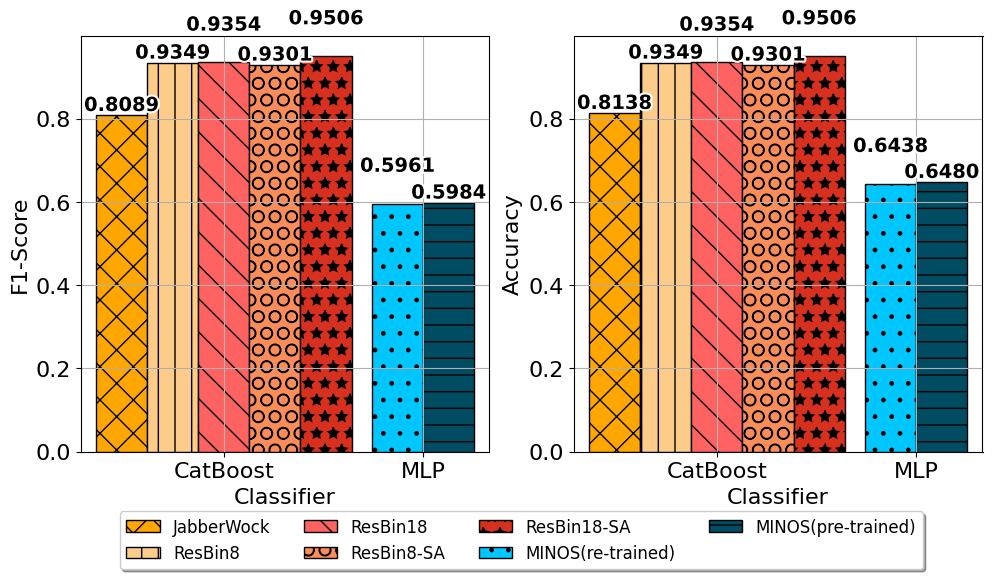

In [46]:
plot_df = pd.DataFrame.from_records(records)
plot_barplot(plot_df, xlabel='Classifier', renamer={})

## Obfuscated Malware detection

In [48]:
import pandas as pd
from sklearn.metrics import classification_report


def get_obfuscated_df(model_name):
    return pd.DataFrame.from_dict({
        'Obfuscation': malware_evaluator.obfuscated_name_test,
        'Transformation': malware_evaluator.obfuscated_technique_test,
        'label': malware_evaluator.obfuscated_y_test,
        'model_name':[model_name for _ in range(len(malware_evaluator.obfuscated_y_test))],
        'indexes':list(range(len(malware_evaluator.obfuscated_y_test)))
    })

def get_test_obfuscations_results(classifiers:list[BaseClassifier], model_names:list[str]):
    records = []
    for (classifier, model_name) in zip(classifiers,model_names):
        if model_name.split('(')[0] =='MINOS':
            model_name, classifier_name = model_name, 'MLP'
        else:
            model_name, classifier_name = model_name.split('+')
        obfuscated_cat_results = get_obfuscated_df(model_name)
        for (Obfuscation, Transformation), df in obfuscated_cat_results.groupby(['Obfuscation', 'Transformation']):
            indexes = df['indexes'].tolist()
            labels = df['label'].tolist()
            rd = classification_report(labels, classifier.predict_from_files(np.array(malware_evaluator.obfuscated_X_test)[indexes])[-1], output_dict=True)
            precision = rd['weighted avg']['precision']
            recall = rd['weighted avg']['recall']
            f1_score = rd['weighted avg']['f1-score']
            accuracy = rd['accuracy']
            records.append({
                'Tool':Obfuscation,
                'Technique':Transformation,
                # 'precision':precision,
                # 'recall':recall,
                'f1-score':f1_score,
                'accuracy':accuracy,
                'model_name':model_name,
                'classifier_name':classifier_name,
            })
    return pd.DataFrame.from_records(records).sort_values(['Tool','Technique'])

df_table = get_test_obfuscations_results(classifiers, model_names)

In [49]:
df_table

,Tool,Technique,f1-score,accuracy,model_name,classifier_name
0,llvm,Basic block splitting,0.772222,0.777778,JabberWock,CatBoost
27,llvm,Basic block splitting,0.888889,0.888889,ResBin8,CatBoost
54,llvm,Basic block splitting,1.000000,1.000000,ResBin18,CatBoost
81,llvm,Basic block splitting,0.944616,0.944444,ResBin8-SA,CatBoost
108,llvm,Basic block splitting,1.000000,1.000000,ResBin18-SA,CatBoost
...,...,...,...,...,...,...
80,wasm-mutate-2,iteration-900,1.000000,1.000000,ResBin18,CatBoost
107,wasm-mutate-2,iteration-900,0.944616,0.944444,ResBin8-SA,CatBoost
134,wasm-mutate-2,iteration-900,1.000000,1.000000,ResBin18-SA,CatBoost
161,wasm-mutate-2,iteration-900,0.396825,0.555556,MINOS(re-trained),MLP


In [50]:
import collections
    
def table_formatter(df, drop_technique=False):
    value_vars = ['f1-score', 'accuracy', ]

    _df = df.copy()
    if drop_technique is False:
        _df = _df.set_index(['Tool', 'Technique'])[value_vars+["model_name", "classifier_name"]]
    else:
        _df = _df.set_index(['Tool',])[value_vars+["model_name", "classifier_name"]]

    metric = value_vars

    model = _df['model_name'].unique()

    d = {}
    for _classifier in _df['classifier_name'].unique():
        _d = {}
        for _model in _df['model_name'].unique():
            _df_t = _df[_df['model_name'] == _model]
            _df_t = _df_t[_df_t['classifier_name'] == _classifier]
            _d[_model] = _df_t.drop(columns=['model_name', 'classifier_name'])
        d[_classifier] = pd.concat(_d, axis=1)

    return pd.concat(d, axis=1), _df

df_for_paper, _ = table_formatter(df_table)
df_for_paper = df_for_paper.dropna(axis=1)

In [51]:
df_for_paper

CatBoost                      \
                                      JabberWock             ResBin8   
                                        f1-score  accuracy  f1-score   
Tool          Technique                                                
llvm          Basic block splitting     0.772222  0.777778  0.888889   
              Bogus control flow        0.833849  0.833333  1.000000   
              Constants encryption      0.565589  0.611111  0.888889   
              Control flow flattening   0.398148  0.444444  0.888889   
              Function wrapper          0.831785  0.833333  1.000000   
              Indirect branches         0.723082  0.722222  0.777778   
              String encryption         0.888889  0.888889  1.000000   
              Substitute instruction    0.708995  0.722222  0.888889   
tigress       Encode arithmetic         0.640693  0.666667  0.944616   
              Function splitting        0.708995  0.722222  0.944616   
              Random functions          0.772222  0.777778  0.944616   
unobfuscated  None                      0.831785  0.833333  0.888889   
wasm-mutate-1 Add Type                  0.831785  0.833333  0.944616   
              Add custom section        0.772222  0.777778  0.944616   
              Add function              0.888889  0.888889  0.888889   
              Code motion               0.888889  0.888889  0.888889   
              Peephole                  0.888889  0.888889  0.888889   
wasm-mutate-2 iteration-100             0.772222  0.777778  0.944616   
              iteration-1000            0.833849  0.833333  0.944616   
              iteration-200             0.719577  0.722222  0.944616   
              iteration-300             0.658009  0.666667  0.944616   
              iteration-400             0.666667  0.666667  0.944616   
              iteration-500             0.658009  0.666667  1.000000   
              iteration-600             0.831785  0.833333  0.944616   
              iteration-700             0.777778  0.777778  0.944616   
              iteration-800             0.833849  0.833333  0.944616   
              iteration-900             0.833849  0.833333  0.944616   

                                                                     \
                                                 ResBin18             
                                       accuracy  f1-score  accuracy   
Tool          Technique                                               
llvm          Basic block splitting    0.888889  1.000000  1.000000   
              Bogus control flow       1.000000  1.000000  1.000000   
              Constants encryption     0.888889  1.000000  1.000000   
              Control flow flattening  0.888889  1.000000  1.000000   
              Function wrapper         1.000000  1.000000  1.000000   
              Indirect branches        0.777778  0.886003  0.888889   
              String encryption        1.000000  1.000000  1.000000   
              Substitute instruction   0.888889  1.000000  1.000000   
tigress       Encode arithmetic        0.944444  1.000000  1.000000   
              Function splitting       0.944444  1.000000  1.000000   
              Random functions         0.944444  1.000000  1.000000   
unobfuscated  None                     0.888889  1.000000  1.000000   
wasm-mutate-1 Add Type                 0.944444  1.000000  1.000000   
              Add custom section       0.944444  1.000000  1.000000   
              Add function             0.888889  1.000000  1.000000   
              Code motion              0.888889  1.000000  1.000000   
              Peephole                 0.888889  1.000000  1.000000   
wasm-mutate-2 iteration-100            0.944444  1.000000  1.000000   
              iteration-1000           0.944444  1.000000  1.000000   
              iteration-200            0.944444  1.000000  1.000000   
              iteration-300            0.944444  1.000000  1.000000   
              iteration-400     

In [61]:
print(
    df_for_paper.to_latex(
        caption="Malware detection inference results.", 
        label="tab:rq3_results", 
        multicolumn_format='c',
        float_format="%.4f",
    ),
)

\begin{table}
\caption{Malware detection inference results.}
\label{tab:rq3_results}
\begin{tabular}{llrrrrrrrrrrrrrr}
\toprule
 &  & \multicolumn{10}{c}{CatBoost} & \multicolumn{4}{c}{MLP} \\
 &  & \multicolumn{2}{c}{JabberWock} & \multicolumn{2}{c}{ResBin8} & \multicolumn{2}{c}{ResBin18} & \multicolumn{2}{c}{ResBin8-SA} & \multicolumn{2}{c}{ResBin18-SA} & \multicolumn{2}{c}{MINOS(re-trained)} & \multicolumn{2}{c}{MINOS(pre-trained)} \\
 &  & f1-score & accuracy & f1-score & accuracy & f1-score & accuracy & f1-score & accuracy & f1-score & accuracy & f1-score & accuracy & f1-score & accuracy \\
Tool & Technique &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{8}{*}{llvm} & Basic block splitting & 0.7722 & 0.7778 & 0.8889 & 0.8889 & 1.0000 & 1.0000 & 0.9446 & 0.9444 & 1.0000 & 1.0000 & 0.3419 & 0.4444 & 0.3419 & 0.4444 \\
 & Bogus control flow & 0.8338 & 0.8333 & 1.0000 & 1.0000 & 1.0000 & 1.0000 & 0.9446 & 0.9444 & 1.0000 & 1.0000 & 0.3704 & 0.5000 & 0.3111 & 0.3889 